## ECE 188 Unfinished Musical Project (GANSynth portion)

### Environmental Setup


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

!rm -r /content/gansynth &>/dev/null
!mkdir /content/gansynth
!mkdir /content/gansynth/midi
!mkdir /content/gansynth/samples
!gsutil -q -m cp gs://magentadata/models/gansynth/acoustic_only.zip /content/gansynth/
!unzip -o /content/gansynth/acoustic_only.zip -d /content/gansynth &>/dev/null
!pip install -q -U magenta==1.1.7

import os
from google.colab import files
import librosa
from magenta import music as mm
from magenta.music.notebook_utils import colab_play as play
from magenta.models.nsynth.utils import load_audio
from magenta.models.gansynth.lib import flags as lib_flags
from magenta.models.gansynth.lib import generate_util as gu
from magenta.models.gansynth.lib import model as lib_model
from magenta.models.gansynth.lib import util
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

download = files.download

def upload():
  filemap = files.upload()
  file_list = []
  for key, value in filemap.iteritems():
    fname = os.path.join('/content/gansynth/midi', key)
    with open(fname, 'w') as f:
      f.write(value)
      print('Writing {}'.format(fname))
    file_list.append(fname)
  return file_list


CKPT_DIR = '/content/gansynth/acoustic_only'
output_dir = '/content/gansynth/samples'
BATCH_SIZE = 16
SR = 16000

OUTPUT_DIR = util.expand_path(output_dir)
if not tf.gfile.Exists(OUTPUT_DIR):
  tf.gfile.MakeDirs(OUTPUT_DIR)

tf.reset_default_graph()
flags = lib_flags.Flags({'batch_size_schedule': [BATCH_SIZE]})
model = lib_model.Model.load_from_path(CKPT_DIR, flags)

def load_midi(midi_path, min_pitch=36, max_pitch=84):
  """Load midi as a notesequence."""
  midi_path = util.expand_path(midi_path)
  ns = mm.midi_file_to_sequence_proto(midi_path)
  pitches = np.array([n.pitch for n in ns.notes])
  velocities = np.array([n.velocity for n in ns.notes])
  start_times = np.array([n.start_time for n in ns.notes])
  end_times = np.array([n.end_time for n in ns.notes])
  valid = np.logical_and(pitches >= min_pitch, pitches <= max_pitch)
  notes = {'pitches': pitches[valid],
           'velocities': velocities[valid],
           'start_times': start_times[valid],
           'end_times': end_times[valid]}
  return ns, notes

def get_envelope(t_note_length, t_attack=0.010, t_release=0.3, sr=16000):
  """Create an attack sustain release amplitude envelope."""
  t_note_length = min(t_note_length, 3.0)
  i_attack = int(sr * t_attack)
  i_sustain = int(sr * t_note_length)
  i_release = int(sr * t_release)
  i_tot = i_sustain + i_release 
  envelope = np.ones(i_tot)

  envelope[:i_attack] = np.linspace(0.0, 1.0, i_attack)

  envelope[i_sustain:i_tot] = np.linspace(1.0, 0.0, i_release)
  return envelope

def combine_notes(audio_notes, start_times, end_times, velocities, sr=16000):

  n_notes = len(audio_notes)
  clip_length = end_times.max() + 3.0
  audio_clip = np.zeros(int(clip_length) * sr)

  for t_start, t_end, vel, i in zip(start_times, end_times, velocities, range(n_notes)):

    t_note_length = t_end - t_start
    envelope = get_envelope(t_note_length)
    length = len(envelope)
    audio_note = audio_notes[i, :length] * envelope
 
    audio_note /= audio_note.max()
    audio_note *= (vel / 127.0)

    clip_start = int(t_start * sr)
    clip_end = clip_start + length
    audio_clip[clip_start:clip_end] += audio_note


  audio_clip /= audio_clip.max()
  audio_clip /= 2.0
  return audio_clip

def specplot(audio_clip):
  p_min = np.min(36)
  p_max = np.max(84)
  f_min = librosa.midi_to_hz(p_min)
  f_max = 2 * librosa.midi_to_hz(p_max)
  octaves = int(np.ceil(np.log2(f_max) - np.log2(f_min)))
  bins_per_octave = 36
  n_bins = int(bins_per_octave * octaves)
  C = librosa.cqt(audio_clip, sr=SR, hop_length=2048, fmin=f_min, n_bins=n_bins, bins_per_octave=bins_per_octave)
  power = 10 * np.log10(np.abs(C)**2 + 1e-6)
  plt.matshow(power[::-1, 2:-2], aspect='auto', cmap=plt.cm.magma)
  plt.yticks([])
  plt.xticks([])

     |████████████████████████████████| 1.5MB 9.2MB/s 
     |████████████████████████████████| 1.6MB 50.4MB/s 
     |████████████████████████████████| 2.9MB 49.3MB/s 
     |████████████████████████████████| 2.4MB 56.5MB/s 
     |████████████████████████████████| 2.3MB 57.0MB/s 
     |████████████████████████████████| 983kB 59.4MB/s 
     |████████████████████████████████| 204kB 75.4MB/s 
     |████████████████████████████████| 808kB 58.9MB/s 
     |████████████████████████████████| 184kB 42.4MB/s 
     |████████████████████████████████| 655kB 67.8MB/s 
     |████████████████████████████████| 368kB 72.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 1.0MB 70.0MB/s 
     |████████████████████████████████| 122kB 72.2MB/s 
     |████████████████████████████████| 143kB 58.2MB/s 
     |████████████████████████████████| 235kB 81.0MB/s 
     |████████████████████████████████| 92kB 11.9MB/s

W1112 00:07:19.547949 140069717137280 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/music/note_sequence_io.py:60: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W1112 00:07:19.550539 140069717137280 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/pipelines/statistics.py:132: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

W1112 00:07:19.554891 140069717137280 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1112 00:07:20.854126 140069717137280 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorf

	adam_beta1: 0.0
	adam_beta2: 0.99
	audio_length: 64000
	batch_size_schedule: [8]
	d_fn: specgram
	data_normalizer: specgrams_prespecified_normalizer
	data_type: mel
	dataset_name: nsynth_tfrecord
	debug_hook: False
	discriminator_ac_loss_weight: 10.0
	discriminator_learning_rate: 0.0008
	fake_batch_size: 61
	fmap_base: 4096
	fmap_decay: 1.0
	fmap_max: 256
	g_fn: specgram
	gan:
	gen_gl_consistency_loss_weight: 0.0
	generator_ac_loss_weight: 10.0
	generator_learning_rate: 0.0008
	gradient_penalty_target: 1.0
	gradient_penalty_weight: 10.0
	kernel_size: 3
	latent_vector_size: 256
	mag_normalizer_a: 0.0661371661726
	mag_normalizer_b: 0.113718730221
	master: 
	normalizer_margin: 0.8
	normalizer_num_examples: 1000
	num_resolutions: 7
	p_normalizer_a: 0.8
	p_normalizer_b: 0.0
	ps_tasks: 0
	real_score_penalty_weight: 0.001
	sample_rate: 16000
	save_summaries_num_images: 10000
	scale_base: 2
	scale_mode: ALL
	simple_arch: False
	stable_stage_num_images: 800000
	start_height: 2
	start_width: 16

W1112 00:07:21.175112 140069717137280 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.ceil is deprecated. Please use tf.math.ceil instead.

W1112 00:07:21.308516 140069717137280 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/magenta/models/gansynth/lib/spectral_ops.py:251: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1112 00:07:21.313833 140069717137280 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/magenta/models/gansynth/lib/spectral_ops.py:251: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1112 00:07:21.969192 140069717137280 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/autograph/converters/directives.

## Generate the custom interpolation for Requim music.

In [0]:
midi_file = "Upload" 

if midi_file == "Upload":
  try:
    file_list = upload()
    midi_path = file_list[0]
    ns, notes_2 = load_midi(midi_path)
  except Exception as e:
    print('Upload Cancelled')
else:
  # Load Default, but slow it down 30%
  ns, notes_2 = load_midi(midi_path)
  notes_2['start_times'] *= 1.3
  notes_2['end_times'] *= 1.3


print('Loaded {}'.format(midi_path))
mm.plot_sequence(ns)

Saving Requiem_v2.mid to Requiem_v2.mid
Writing /content/gansynth/midi/Requiem_v2.mid
Loaded /content/gansynth/midi/Requiem_v2.mid


In [0]:
number_of_random_instruments = 4 # Set to four instruments
pitch_preview = 60
n_preview = number_of_random_instruments

pitches_preview = [pitch_preview] * n_preview
z_preview = model.generate_z(n_preview)

audio_notes = model.generate_samples_from_z(z_preview, pitches_preview)
for i, audio_note in enumerate(audio_notes):
  print("Instrument: {}".format(i))
  play(audio_note, sample_rate=16000)


generate_samples: generated 4 samples in 0.0689518451691s
Instrument: 0


Instrument: 1


Instrument: 2


Instrument: 3


Generating 1838 samples...
generate_samples: generated 1838 samples in 14.2717678547s

Audio:


CQT Spectrogram:


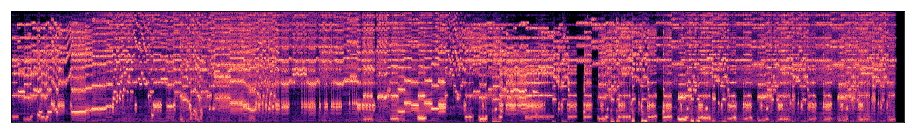

In [0]:
instruments = [1, 2, 1, 2]

times = [0, 0.3, 0.6, 1.0] 

times[0] = -0.001
times[-1] = 1.0

z_instruments = [z_preview[i] for i in instruments]
t_instruments = [notes_2['end_times'][-1] * t for t in times]

z_notes = gu.get_z_notes(notes_2['start_times'], z_instruments, t_instruments)

print('Generating {} samples...'.format(len(z_notes)))
audio_notes = model.generate_samples_from_z(z_notes, notes_2['pitches'])

audio_clip = combine_notes(audio_notes,
                           notes_2['start_times'],
                           notes_2['end_times'],
                           notes_2['velocities'])

print('\nAudio:')
play(audio_clip, sample_rate=SR)
print('CQT Spectrogram:')
specplot(audio_clip)


In [0]:
#@title Download
#@markdown Get the .wav file (optional)

# Write the file
fname = os.path.join(output_dir, 'generated_clip.wav')
gu.save_wav(audio_clip, fname)
download(fname)

Saved to /content/gansynth/samples/generated_clip.wav


## Generate a custom interpolation for the Turandot music.


In [4]:
midi_file = "Upload" 

if midi_file == "Upload":
  try:
    file_list = upload()
    midi_path = file_list[0]
    ns, notes_2 = load_midi(midi_path)
  except Exception as e:
    print('Upload Cancelled')
else:
  ns, notes_2 = load_midi(midi_path)
  notes_2['start_times'] *= 1.3
  notes_2['end_times'] *= 1.3


print('Loaded {}'.format(midi_path))
mm.plot_sequence(ns)

Saving Turandot_v2.mid to Turandot_v2.mid
Writing /content/gansynth/midi/Turandot_v2.mid
Loaded /content/gansynth/midi/Turandot_v2.mid


In [13]:


number_of_random_instruments = 4 # Set to four instruments
pitch_preview = 60
n_preview = number_of_random_instruments

pitches_preview = [pitch_preview] * n_preview
z_preview = model.generate_z(n_preview)

audio_notes = model.generate_samples_from_z(z_preview, pitches_preview)
for i, audio_note in enumerate(audio_notes):
  print("Instrument: {}".format(i))
  play(audio_note, sample_rate=16000)



generate_samples: generated 4 samples in 0.0694220066071s
Instrument: 0


Instrument: 1


Instrument: 2


Instrument: 3


Generating 1644 samples...
generate_samples: generated 1644 samples in 12.7805039883s

Audio:


CQT Spectrogram:


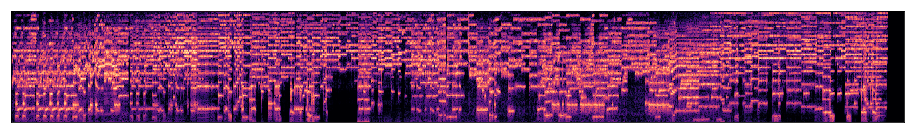

In [14]:

instruments = [0, 1, 0, 1] 

times = [0, 0.3, 0.6, 1.0] 

times[0] = -0.001
times[-1] = 1.0

z_instruments = [z_preview[i] for i in instruments]
t_instruments = [notes_2['end_times'][-1] * t for t in times]

z_notes = gu.get_z_notes(notes_2['start_times'], z_instruments, t_instruments)

print('Generating {} samples...'.format(len(z_notes)))
audio_notes = model.generate_samples_from_z(z_notes, notes_2['pitches'])

audio_clip = combine_notes(audio_notes,
                           notes_2['start_times'],
                           notes_2['end_times'],
                           notes_2['velocities'])

print('\nAudio:')
play(audio_clip, sample_rate=SR)
print('CQT Spectrogram:')
specplot(audio_clip)


In [15]:
fname = os.path.join(output_dir, 'generated_clip.wav')
gu.save_wav(audio_clip, fname)
download(fname)

Saved to /content/gansynth/samples/generated_clip.wav
